# CVI and IconMAP dataset analysis

Reference:
Analysis of biobanked serum from a bovine Mycobacterium avium subsp paratuberculosis infection model confirms the remarkable stability of circulating miRNA profiles and defines a bovine serum miRNA repertoire.

Ronan Shaughnessy, Damien Farrell, Karel Riepema, Douwe Bakker, Stephen V. Gordon


In [4]:
#douwe data analysis
import glob,os
import pandas as pd
import numpy as np
import mirnaseq.mirdeep2 as mdp
import mirnaseq.srnabench as srb
from mirnaseq import base, analysis, ensembl
pd.set_option('display.width', 300)
%matplotlib inline
import pylab as plt
import seaborn as sns
sns.set_style("ticks", {'axes.facecolor': '#F7F7F7','legend.frameon': True})
sns.set_context("notebook", font_scale=1.8)
plt.rcParams['savefig.dpi']=150

In [2]:
reload(mdp)
path='/opt/mirnaseq/data/douwe/'
os.chdir(path)
path1='analysis/douwe_mirdeep_rnafiltered'
path2='analysis/douwe_srnabench_rnafiltered'
df = mdp.getResults(path1)
#df = df.set_index('#miRNA')
k = df[df.novel==False]
n = df[df.novel==True]
n.to_csv('douwe_novel_all.csv')

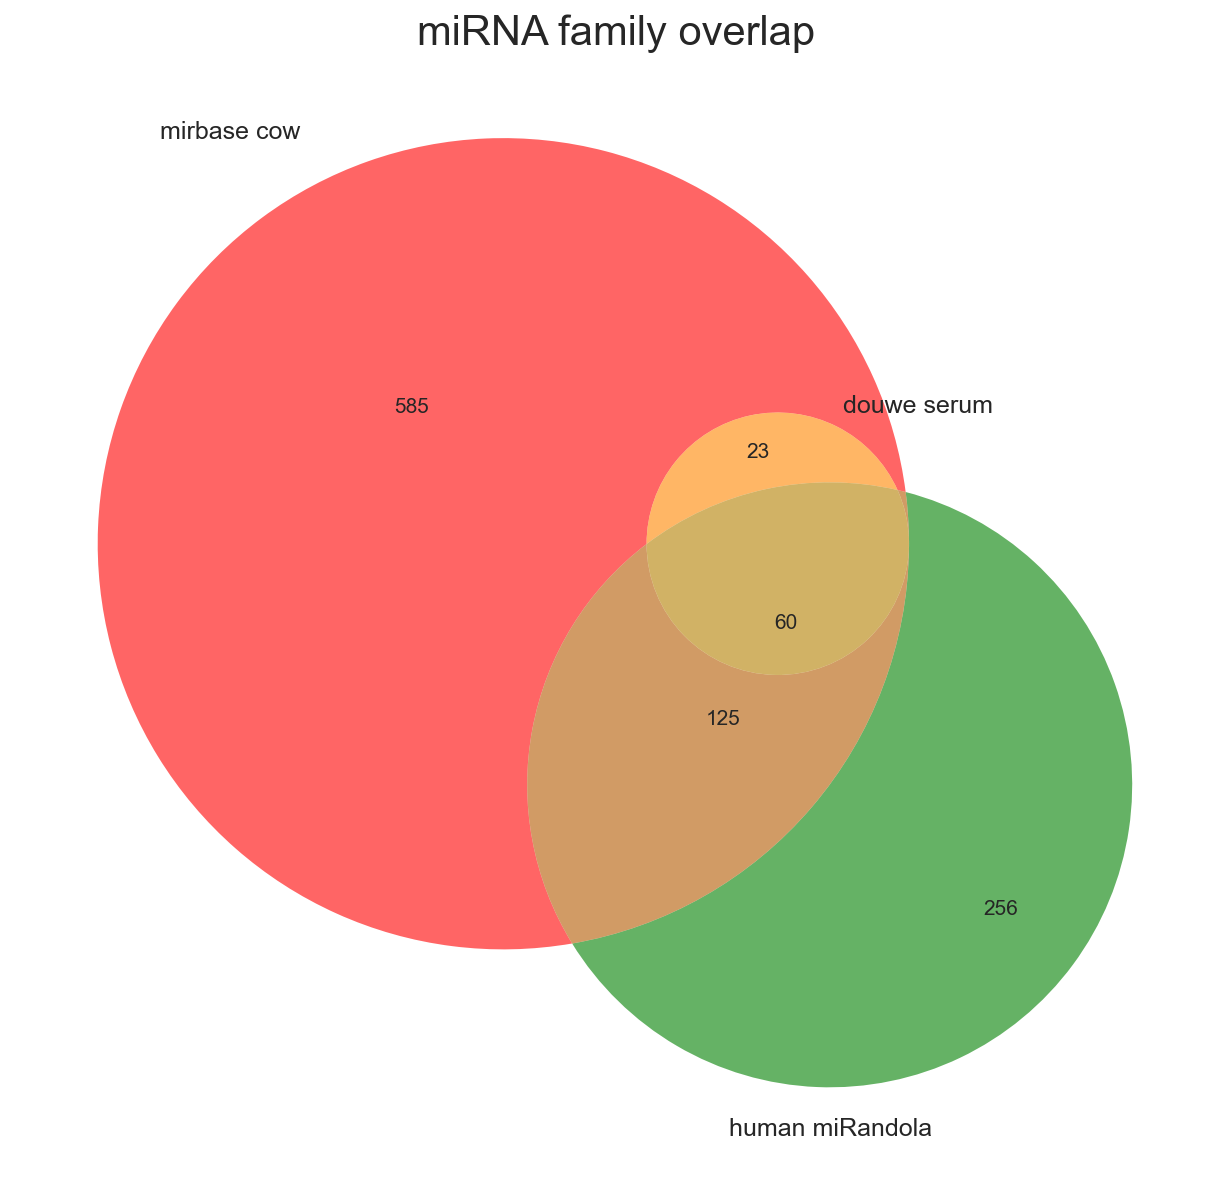

In [3]:
#overlap between our miRs and other circulating studies?
mirbase = base.fasta2DataFrame('mature_btau_alt.fa').reset_index()
mb = mirbase.name.str.replace('bta-','')
k = mdp.filterExprResults(k,meanreads=150)
a = k['#miRNA'].str.replace('bta-','')
mdla = pd.read_csv('/opt/mirnaseq/analysis/miRandola_1.6.csv')
h1 = mdla[mdla.miRNA_type=='circulating'].name.str.replace('hsa-','')
f,ax=plt.subplots(1,1,figsize=(10,8))
#print set(h)-set(a)
v=base.venndiagram([mb,a,h1],['mirbase cow','douwe serum','human miRandola'],ax, set_colors=['r','y','g'], alpha=0.6)
ax.set_title('miRNA family overlap',fontsize=20)
plt.tight_layout()
f.savefig('known_overlap.png')

In [ ]:
#convservation of families for known results
known = pd.read_csv('known_mirdeep.csv')
#m = mdp.getResults(path)
#known = m[m.novel==False]
#known = mdp.filterExprResults(known,meanreads=50)
mbf = analysis.getmiFam()
fams = mbf.groupby('family').agg({'name':np.size}).reset_index()
fams=fams.rename(columns={'name':'size'})
names = pd.Series(known.precursor).str.lower()
x = mbf[mbf.name.isin(names)]
x=x.merge(fams,on='family')
print x.sort('size')[:10]

isoall = pd.read_csv('srnabench_isomirs_all.csv')
g = isoall.groupby('name', as_index=False)
l = g.agg({'length':np.size})
#print l

In [5]:
#novel
novel = pd.read_csv('novel_conserved.csv')
#known = pd.read_csv('known_mirdeep.csv').set_index('#miRNA')
mirbase = base.fasta2DataFrame('mature.fa')
#print isoall[:1]
for i,r in novel.iterrows():
    name=r['#miRNA']
    ms=r['consensus mature sequence']
    ref = r['mirbase'].replace('hsa','bta')
    if ref in mirbase.index:
        refsq =  mirbase.ix[ref]['sequence'].lower()
    else:
        refsq = ''
    print name,ms,ref,refsq

IOError: File novel_conserved.csv does not exist

In [23]:
#novel conservation
reload(ensembl)
df = pd.read_csv('novel_mirdeep.csv')
ort = pd.read_csv('novel_orthologs.csv')
#print ort[ort['#miRNA']=='14_5598']
#ensembl.getmiRNAOrthologs(df)
x=ensembl.summarise(df)
print x[x.columns[2:11]]

             energy      tu  seedcons         biotype     gene  read_count  miRDeep2 score mirbase seed match     precursor coordinate
#miRNA                                                                                                                                
20_11630 -33.200001  intron         1  protein_coding   ZSWIM6         718             5.1      hsa-miR-1255a  20:17904153..17904232:-
28_16560 -30.100000     NaN         2             NaN      NaN         471             5.3    hsa-miR-4766-5p    28:9347067..9347134:-
12_3861  -20.400000    exon         2           snRNA       U2       15465             4.0       hsa-miR-1246  12:69698007..69698073:-
14_5598  -11.000000  intron         2  protein_coding  C8orf37        1917           852.3                  -  14:71406692..71406740:-
9_24296  -18.299999     NaN         2             NaN      NaN         304             5.1     hsa-miR-142-5p   9:86842891..86842959:+
13_4103         NaN  intron         0  protein_coding  

In [6]:
def getfiltered(path, cut=150):
    df = mdp.getResults(path)
    print df.read_count.sum()
    df = df[df.novel==False]
    df = mdp.filterExprResults(df,meanreads=cut)
    return df

douwe = getfiltered(path1)
#iconmap
iconmap = getfiltered('/opt/mirnaseq/data/iconmap/analysis/iconmap_results_mirdeep')
#nick
nick = getfiltered('/opt/mirnaseq/data/nick/analysis/nick_results_mirdeep')
#vegh
vegh = getfiltered('/opt/mirnaseq/data/vegh_13/analysis/vegh_results_mirdeep')
#hooten paper results
hooten = getfiltered('/opt/mirnaseq/data/hooten_13/analysis/hooten13_results_mirdeep')


2135533.0
10684392.0
6201514.0
40229562.0
4527911.0


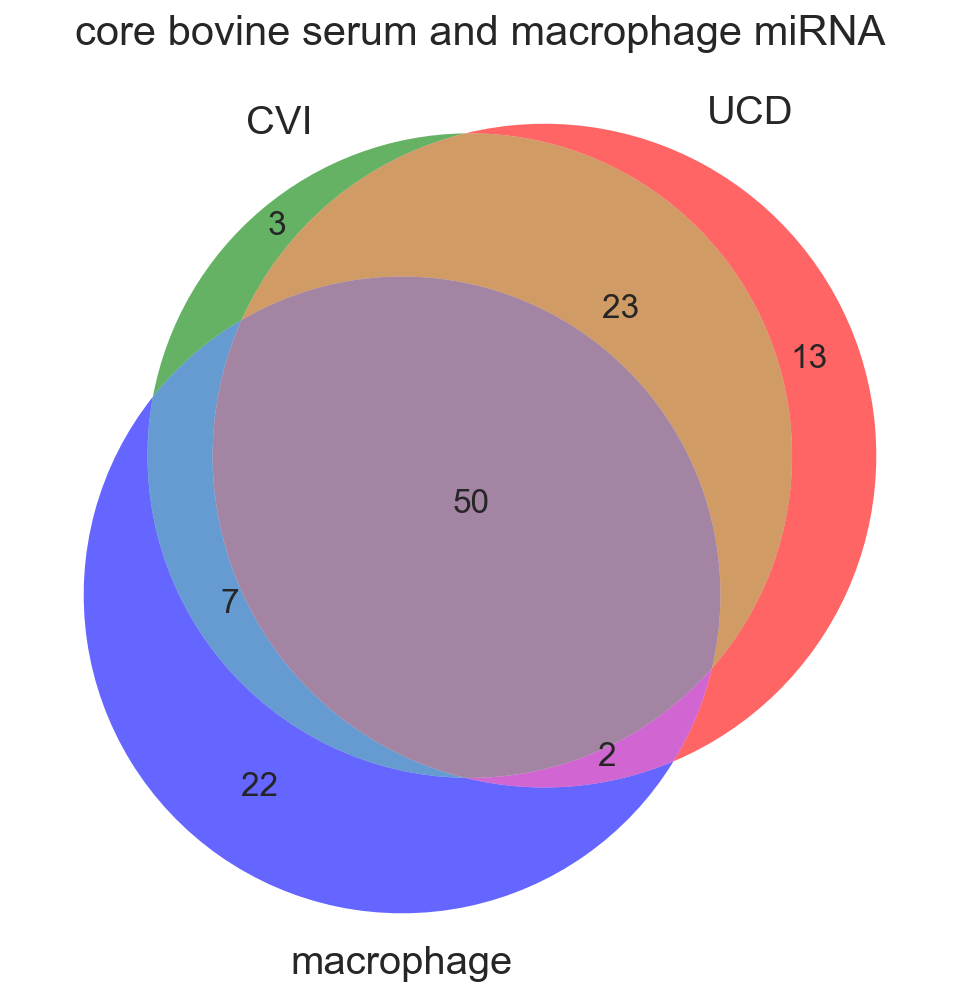

In [7]:
d = douwe['#miRNA']
ic = iconmap['#miRNA']
n = nick['#miRNA']
v = vegh['#miRNA']
plt.rcParams['font.size']=16
f,ax=plt.subplots(1,1,figsize=(8,8))
base.venndiagram([d,ic,v],['CVI','UCD','macrophage'],ax, set_colors=['g','r','b'], alpha=0.6)
ax.set_title('core bovine serum and macrophage miRNA',fontsize=20)
#b.plot(y='mean',kind='barh',figsize=(10,10))
f.savefig('oldvsfresh_overlap.png')

cc=0.866716177407


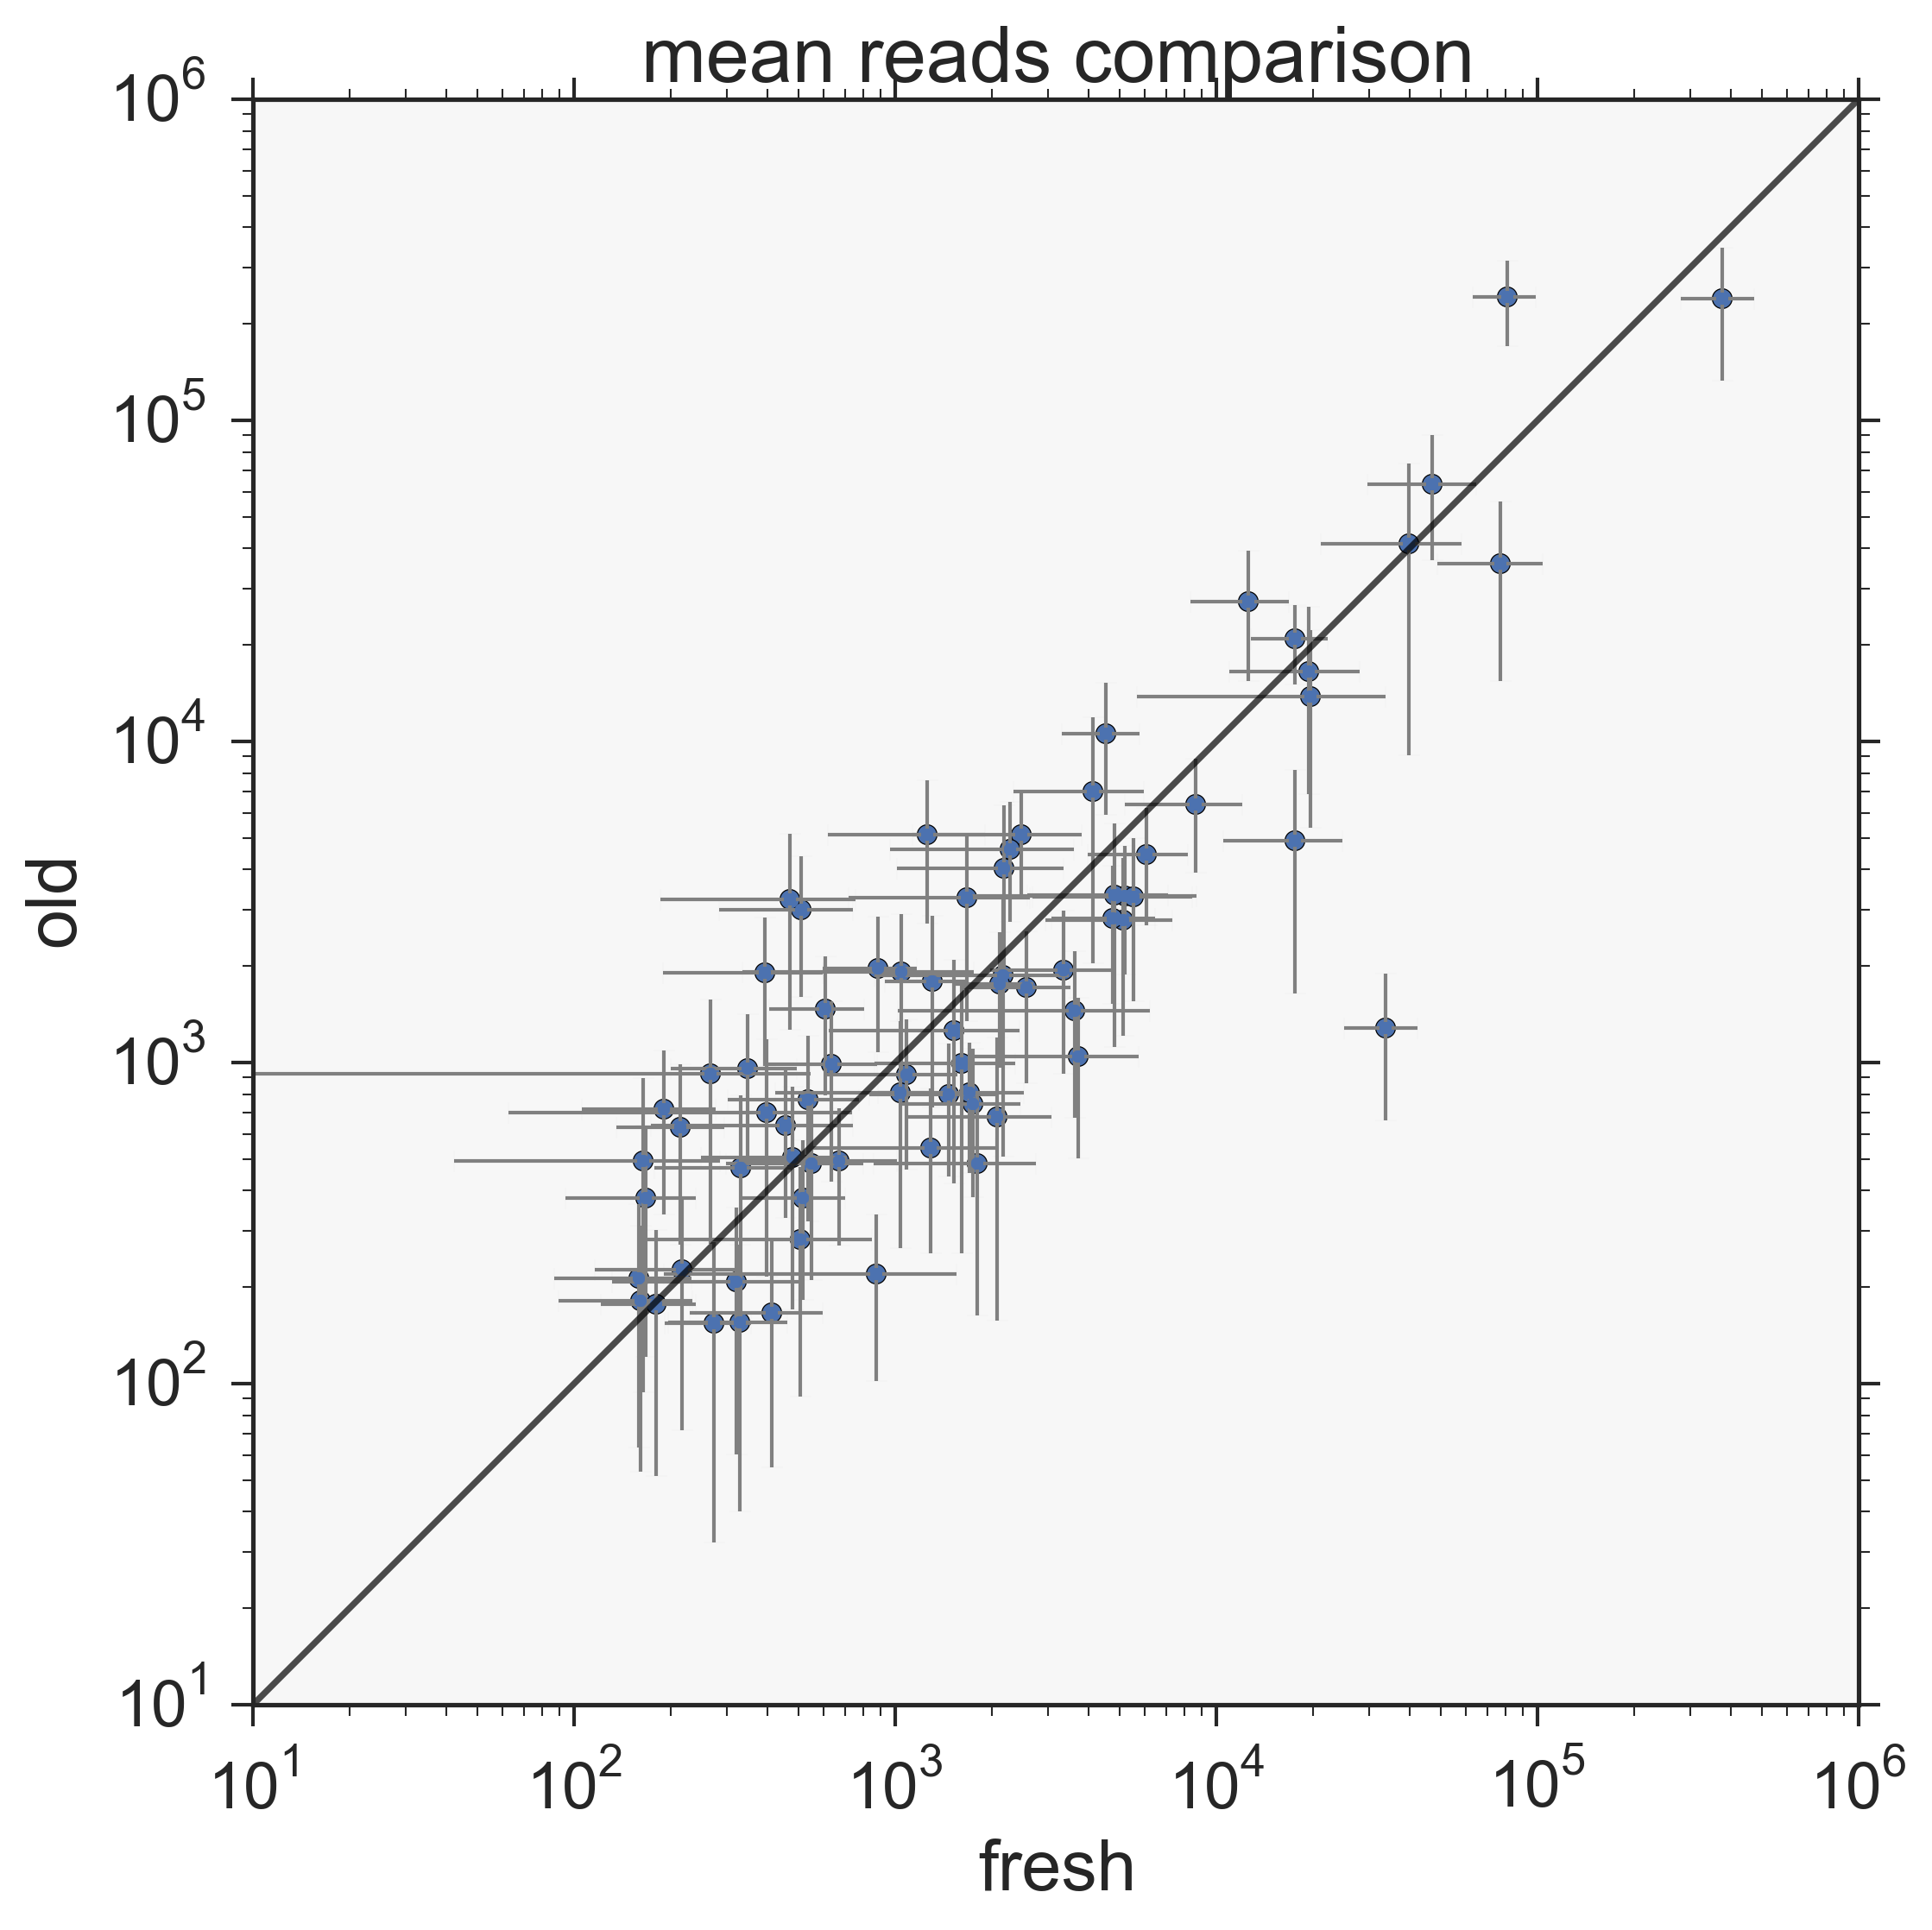

In [38]:
#per mirna expression comparison between fresh and old

def getexprdata(df, norm=True):
    #get variance data
    cols,normcols=mdp.getColumnNames(df)
    if norm==True:
        c=normcols
    else:
        c=cols
    d=df[['#miRNA','mean_norm']]
    d['std'] = df[c].std(1)
    return d

d = getexprdata(douwe)
ic = getexprdata(iconmap)

#c=['#miRNA']+normcols
#t = pd.melt(x[:20][c],id_vars='#miRNA',var_name='sample',value_name='mean')
#g=sns.factorplot('#miRNA','mean',data=t, kind="bar",aspect=1.8,palette='Spectral')

x = pd.merge(ic,d,on='#miRNA')
f,ax=plt.subplots(1,1,figsize=(8,8))
x.plot('mean_norm_x','mean_norm_y',kind='scatter',logx=True, grid=False,
       logy=True,s=30,ax=ax)
ax.errorbar(x=x.mean_norm_x,y=x.mean_norm_y, xerr=x.std_x,yerr=x.std_y,fmt='.',ecolor='gray', elinewidth=1)
ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='black',alpha=0.7)
ax.set_xlabel('fresh')
ax.set_ylabel('old')
ax.set_title('mean reads comparison')
f.savefig('oldvsfresh_correlation.png')
print 'cc=%s' %np.corrcoef(np.log2(x.mean_norm_x),np.log2(x.mean_norm_y))[0][1]


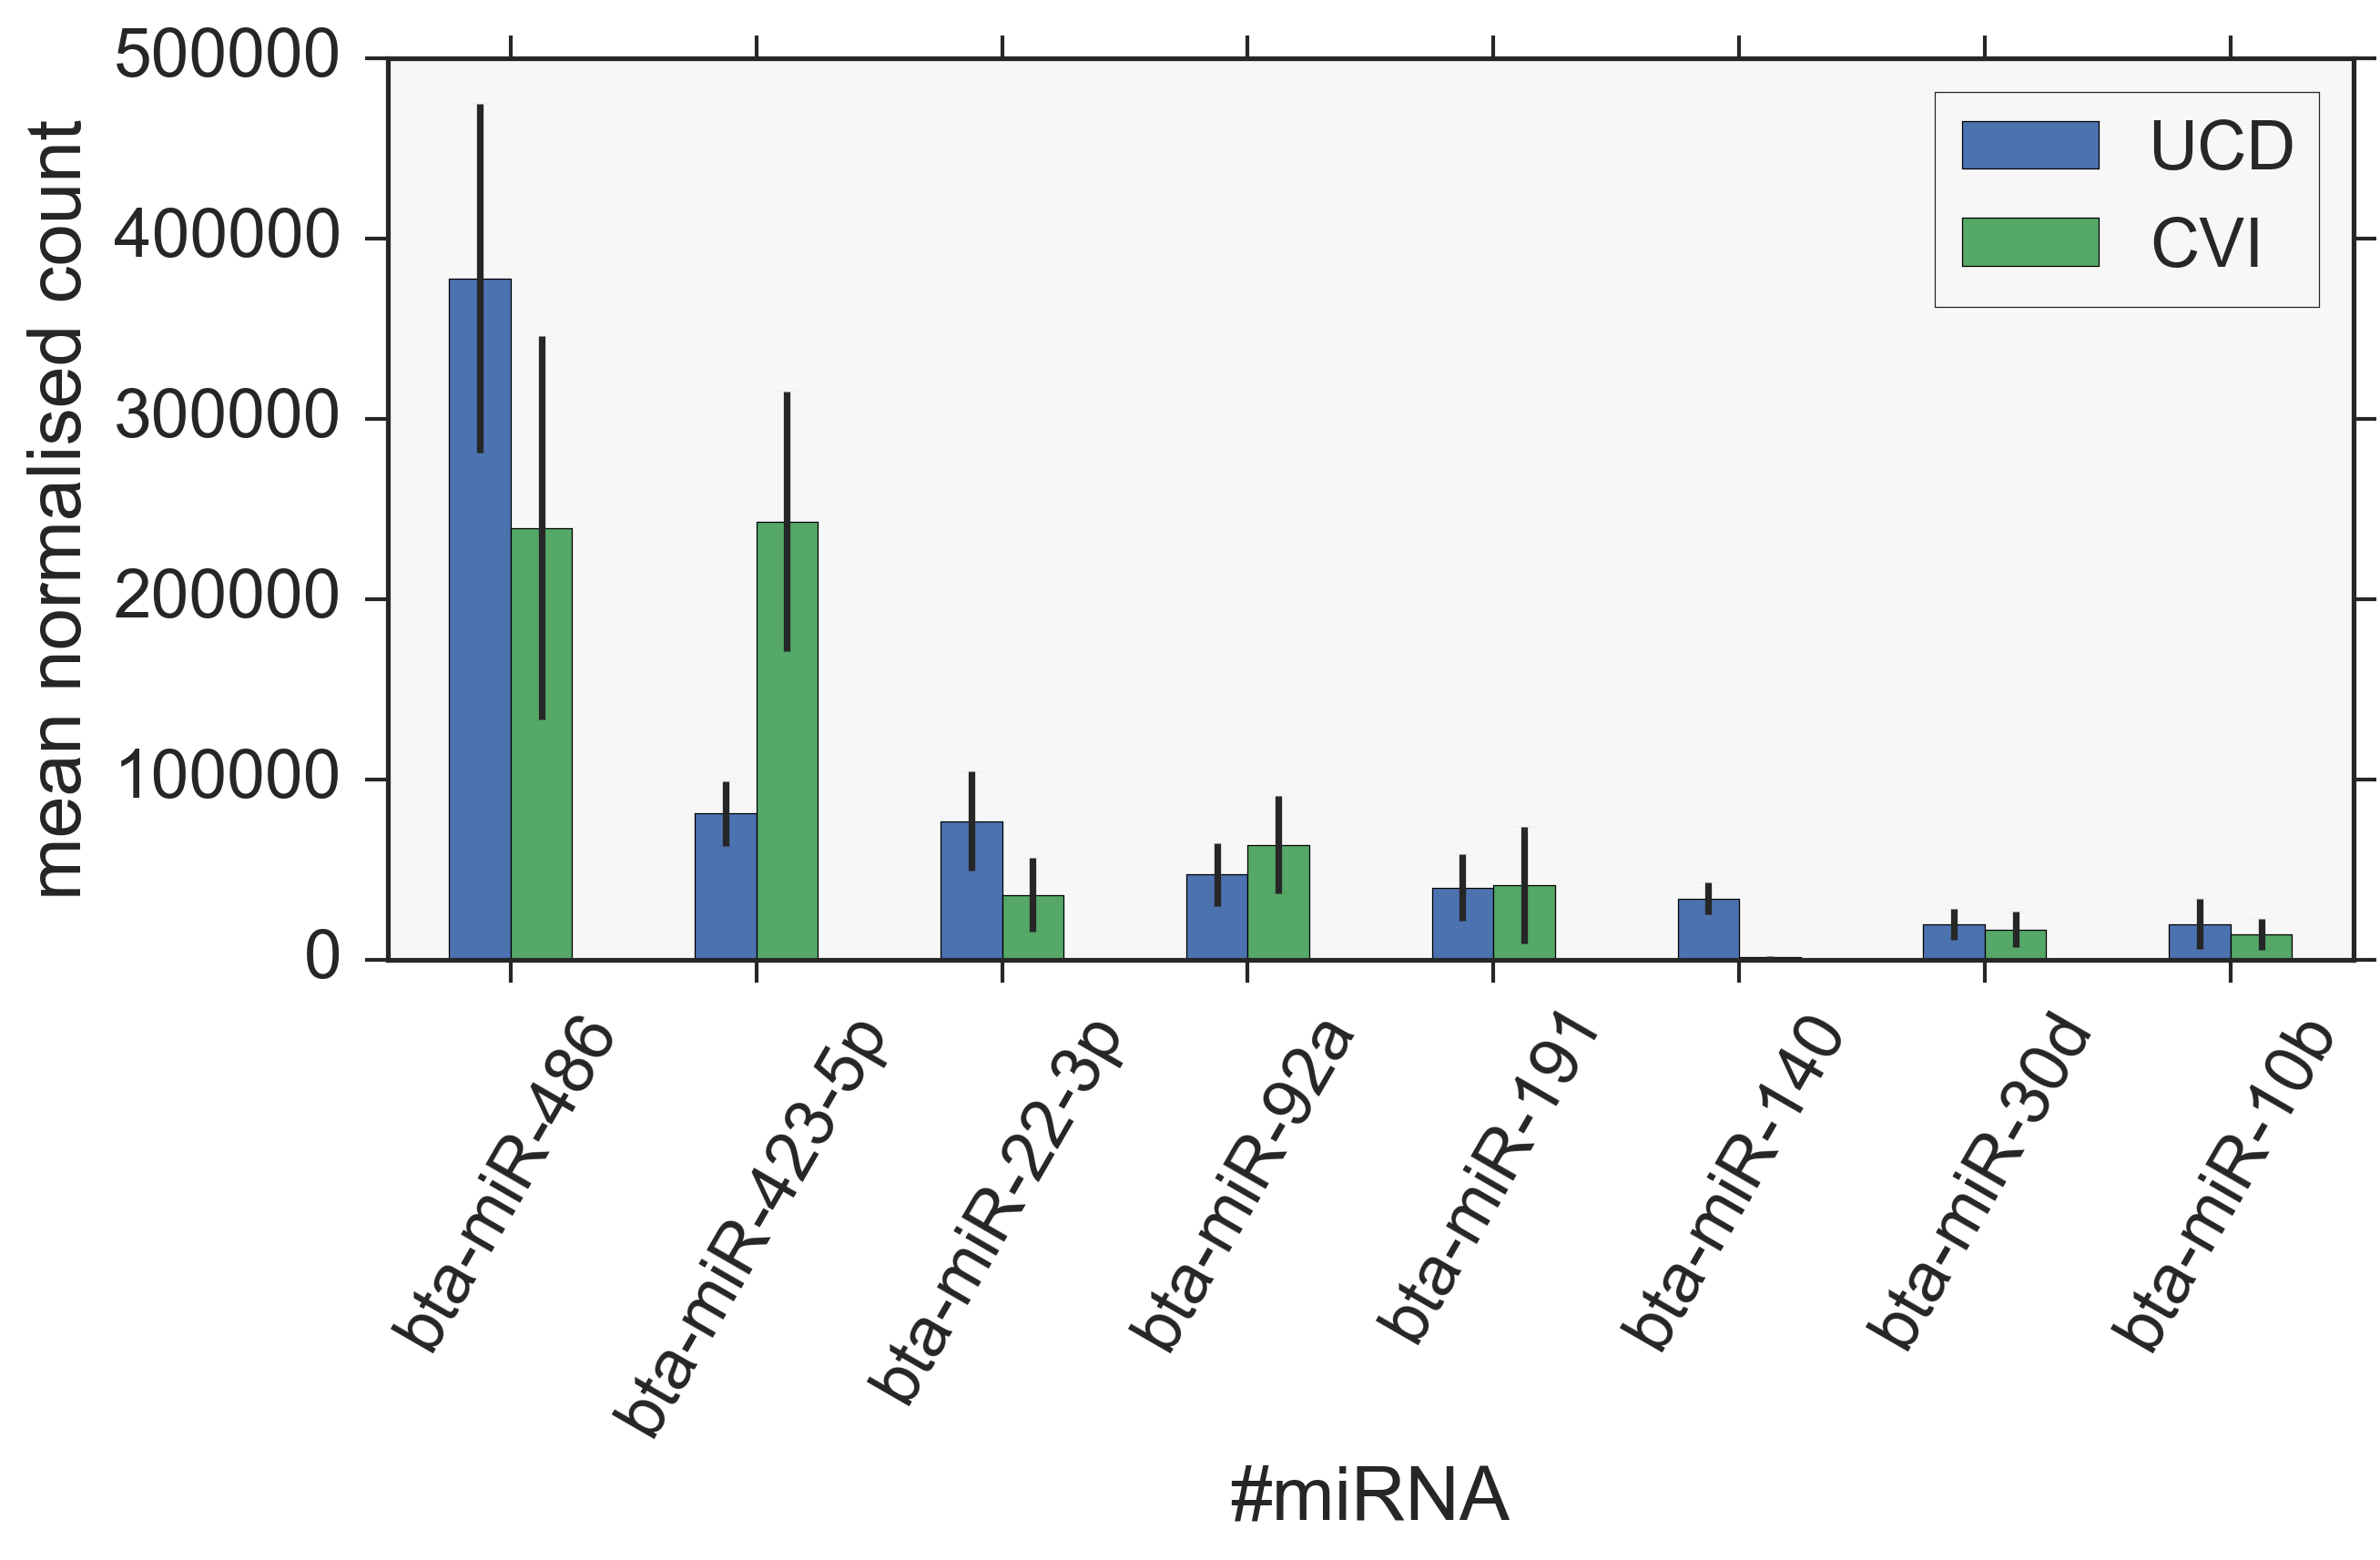

In [30]:
#top comparisons
top=x.set_index('#miRNA')[:8]
vals = top[['mean_norm_x','mean_norm_y']]
errs = top[['std_x','std_y']]
errs=errs.rename(columns={'std_x':'mean_norm_x','std_y':'mean_norm_y'})
ax=vals.plot(yerr=errs,kind='bar',grid=False,figsize=(9,6))
plt.ylabel('mean normalised count')
plt.legend(['UCD','CVI'])
ax.set_xticklabels(x['#miRNA'],rotation=60)
plt.tight_layout()
plt.savefig('oldvsfresh_top.png')

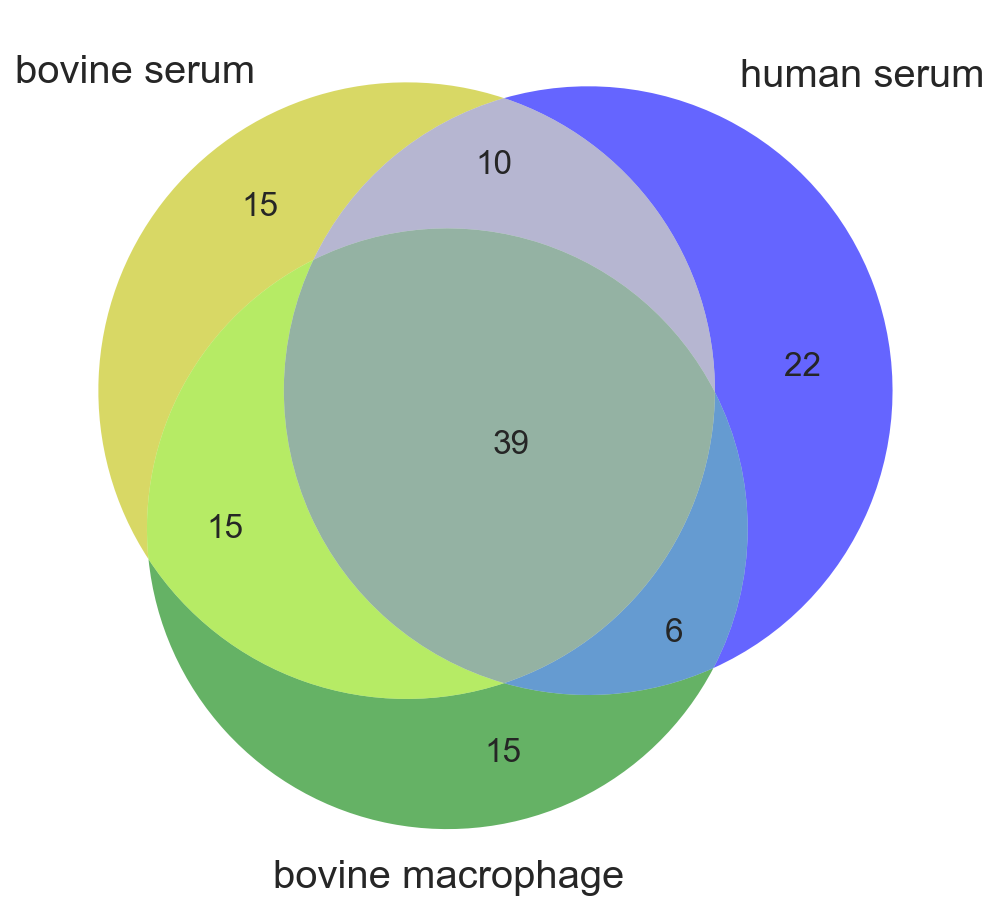

In [12]:
a = douwe['precursor'].str.replace('bta-','')
b = hooten['precursor'].str.replace('hsa-','')
c = vegh['precursor'].str.replace('bta-','')

f,ax=plt.subplots(1,1,figsize=(8,8))
v=base.venndiagram([a,b,c],['bovine serum','human serum','bovine macrophage'], ax, set_colors=['y','b','g'], alpha=0.6)

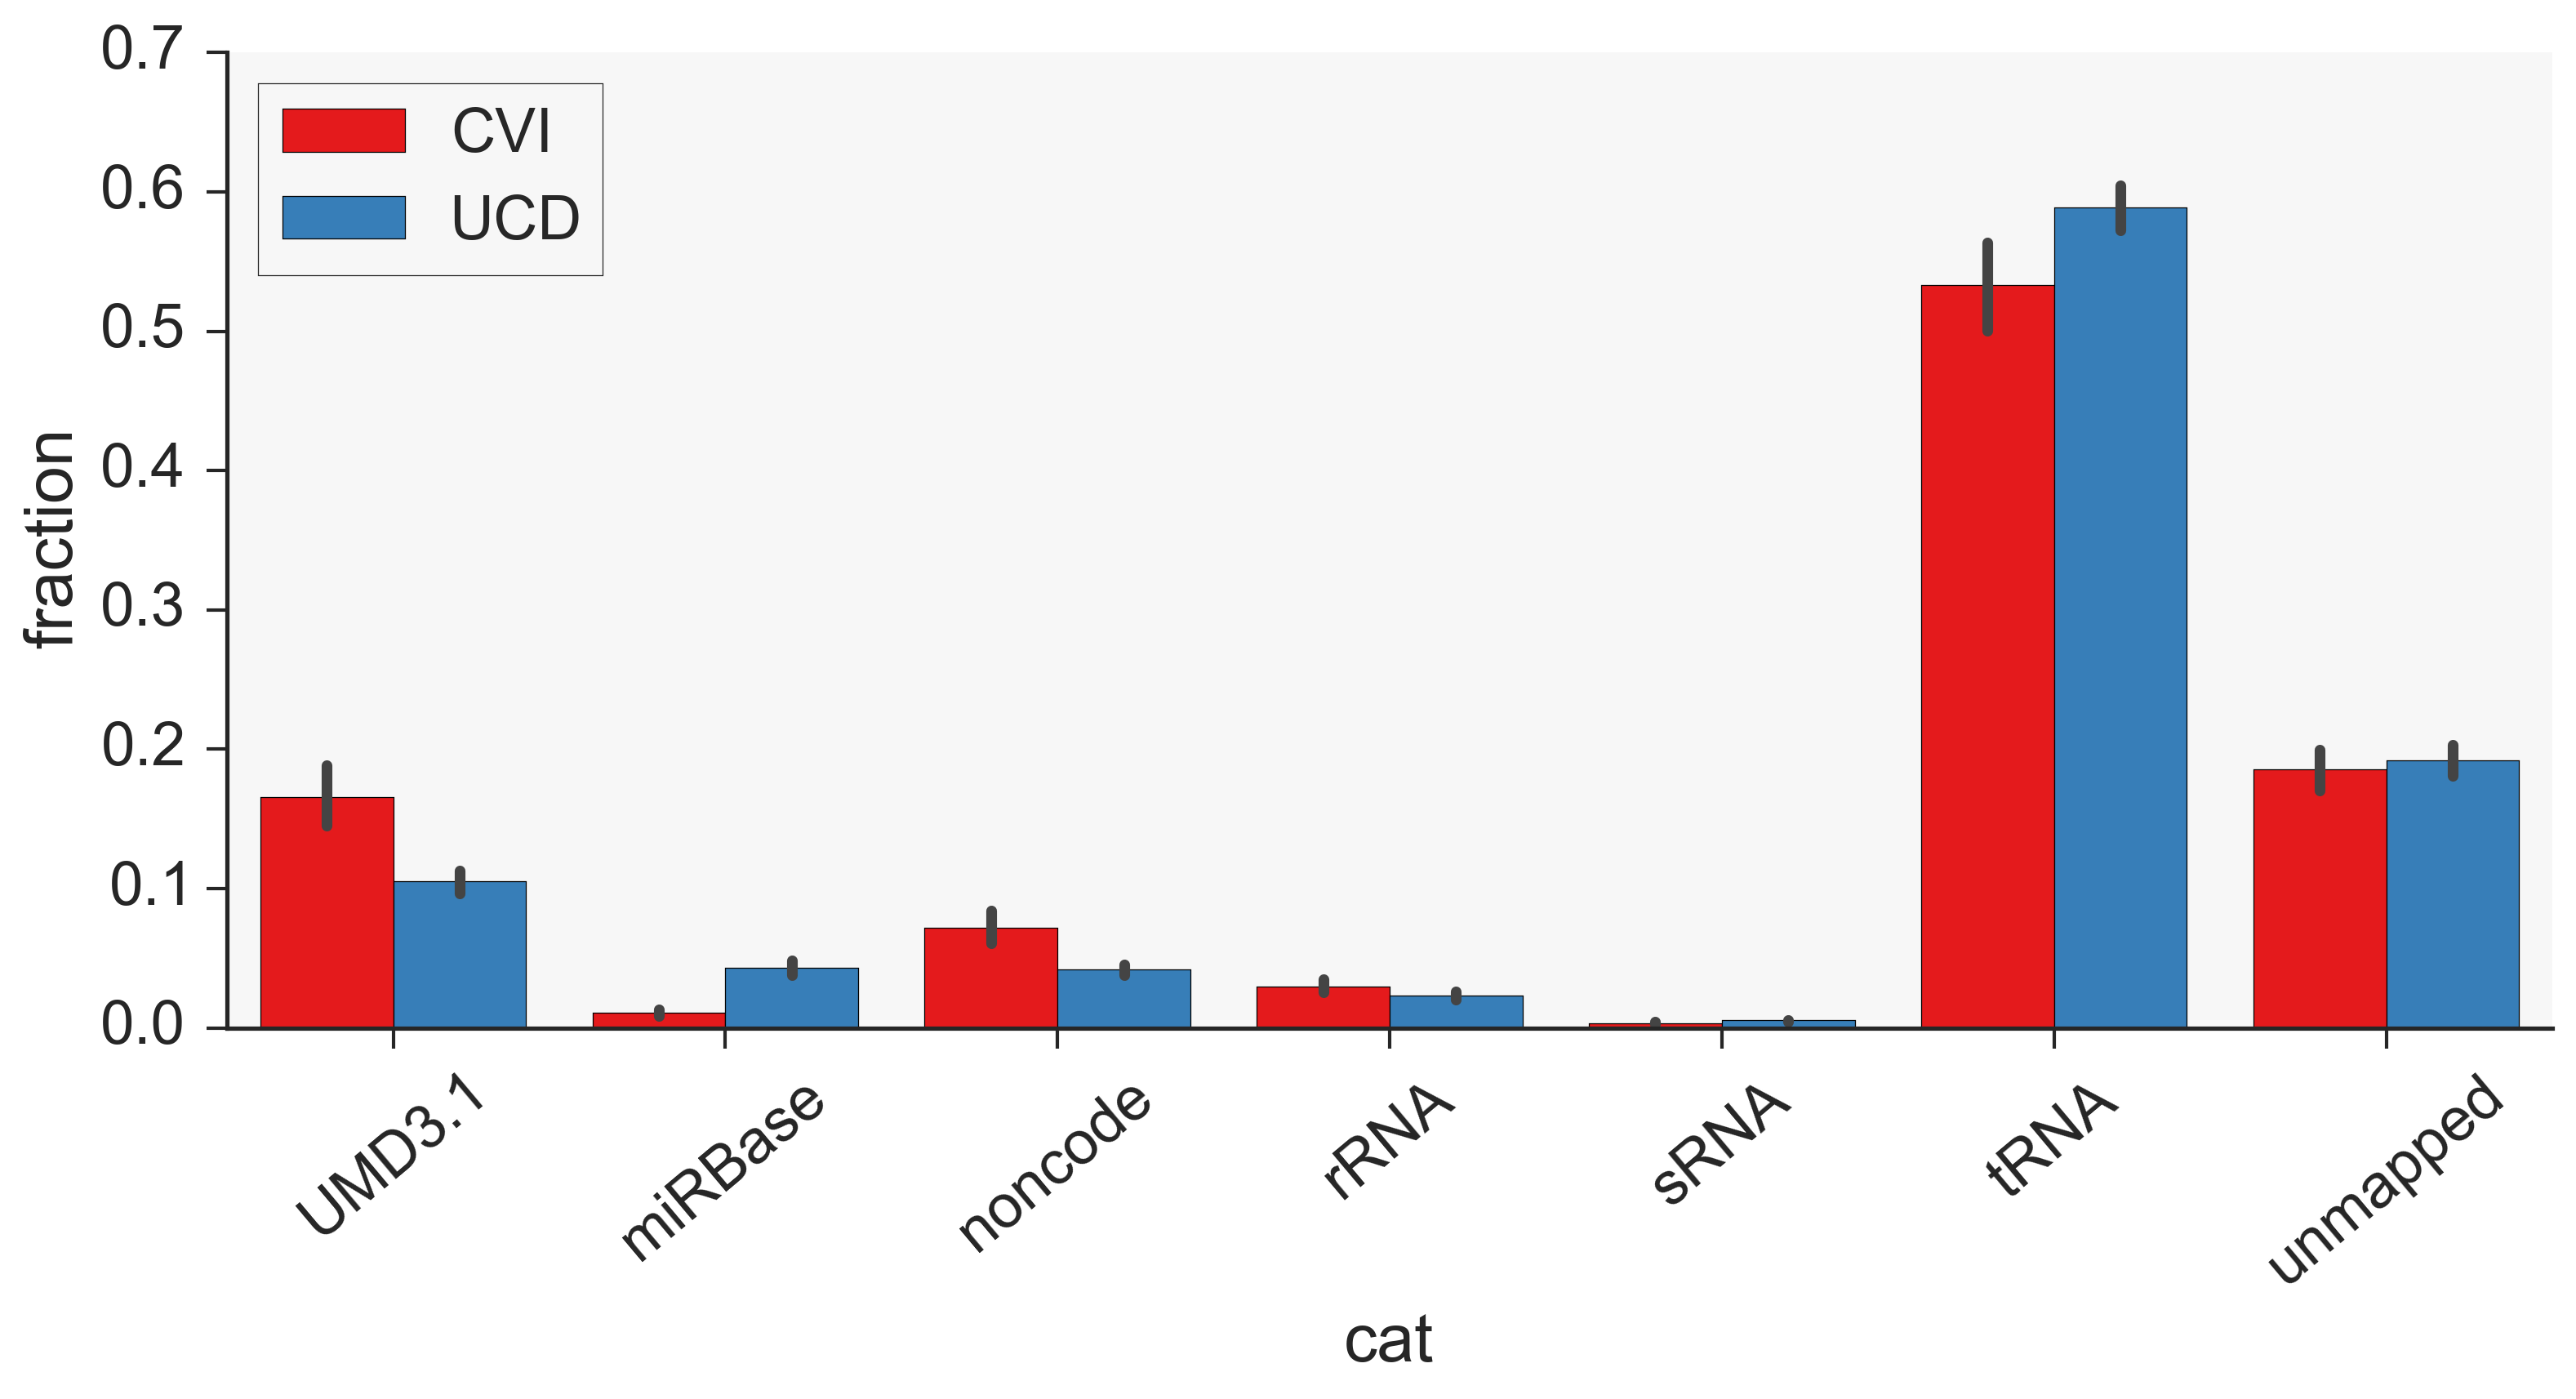

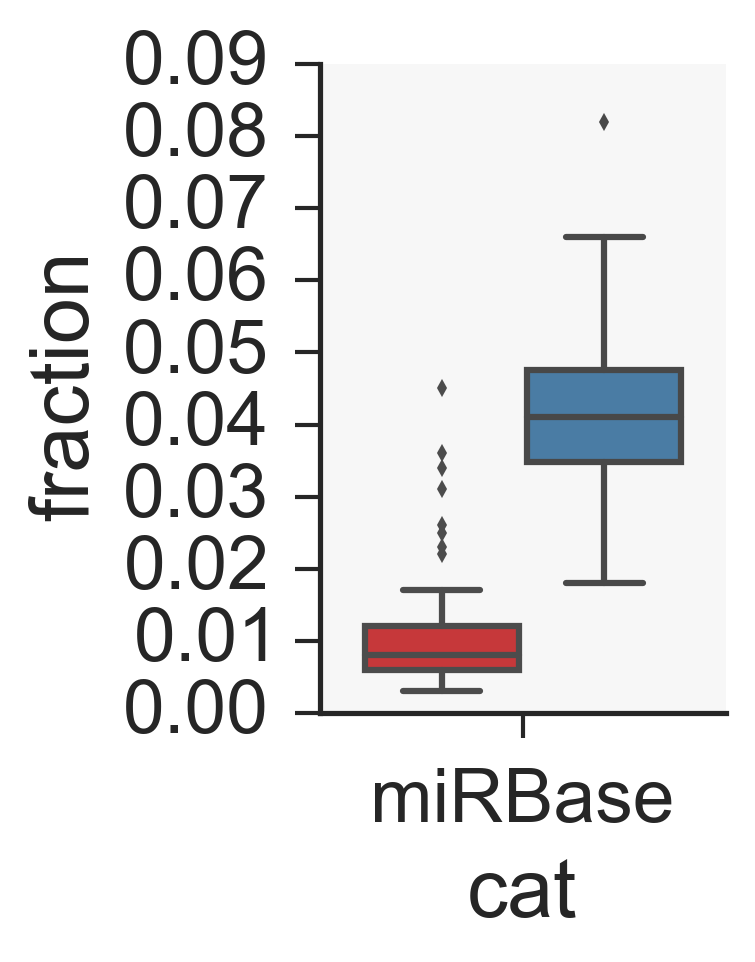

In [35]:
#ncrna iconmap and douwe compare..
nc1 = pd.read_csv('ncrna_mapped.csv',index_col=0)
nc2 = pd.read_csv('iconmap_ncrna.csv',index_col=0)
nc1['name']='CVI'
nc2['name']='UCD'
x=pd.concat([nc1,nc2])
x=x.drop(['total'],1)
x['unmapped'] = 1-x.sum(1)
catnames = {'mirbase-hairpin':'miRBase','Rfam_btau':'rRNA','bosTau6-tRNAs':'tRNA','unmapped':'unmapped',
        'bostau-snRNA':'sRNA','noncodev4_btau':'noncode','bos_taurus_alt':'UMD3.1'}
x = x.rename(columns=catnames)
t = pd.melt(x,id_vars=['name'],var_name='cat',value_name='total')
g=sns.factorplot('cat','total','name', t, kind="bar",aspect=1.8,size=6,palette='Set1',legend=False)
plt.legend(loc=2)
g.set_xticklabels(rotation=40)
g.set(ylabel='fraction')
plt.tight_layout()
plt.savefig('oldvsfresh_ncrna.png')
#plot just mirnas
t = t[t.cat=='miRBase']
g=sns.factorplot('cat','total','name', t,kind="box",size=3.5,aspect=.8,palette='Set1',legend=False)
g.axes[0]
g.set(ylabel='fraction')
plt.savefig('oldvsfresh_mirna.png')


In [16]:
def DEbytime(df, condmap, times, cut=1.5):
    elisa=['N','P']    
    res=[]
    print times
    for e in elisa:
        c = condmap[condmap.elisa==e]
        c = c[c.timegroup.isin(times)]
        x = pd.Categorical(c['timegroup'],categories=times)        
        c['factor'] = x.labels
        c['label'] = c.apply(lambda x: x.id+'_'+str(x.factor),1)
        c = c.sort('factor')        
        scols = c.id        
        data = df[scols]        
        data.columns = c.label        
        data.to_csv('decounts.csv')
        de = base.runEdgeR('decounts.csv', cut)
        de['elisa']=e
        res.append(de)
        print de
    detime = pd.concat(res)    
    detime.to_csv('de_time.csv')
    return detime

In [17]:
#diffr expression
times = [['START','EARLY'],['START','LATE']]

df = mdp.getResults(path1)
k=df[df.novel==False]
k = mdp.filterExprResults(k,meanreads=150)
cm1 = mdp.getLabelMap(path1, 'mapdata_labels.csv')
k=k.set_index('#miRNA')
for t in times:
    deknown = DEbytime(k, cm1, t)

#isomir diffr expression
cm2 = srb.getLabelMap(path2, 'mapdata_labels.csv')
iso = pd.read_csv('analysis/srnabench_isomirs_all.csv')
df = iso[(iso.mean_norm>50) & (iso.freq>0.9)]
#create unique names for isomirs
df['tag'] = df.name+'_'+df.variant+'_'+df.pos.astype(str)+'_'+df.index.astype(str)
df = df.set_index('tag')
res=[]
for t in times:
    d = DEbytime(df, cm2, t, cut=2)
    res.append(d)
deiso=pd.concat(res)    
kiso=df

['START', 'EARLY']
 [1] "0" "0" "0" "0" "0" "0" "0" "1" "1" "1" "1" "1" "1" "1"

          name     logFC     logCPM    PValue       FDR elisa
0  bta-miR-205  2.067765   8.779463  0.000064  0.001328     N
1  bta-miR-92b  1.639678  11.523647  0.000014  0.001166     N
2  bta-miR-29a  1.511802   9.118137  0.000039  0.001328     N
 [1] "0" "0" "0" "0" "0" "1" "1" "1" "1" "1"

          name     logFC     logCPM    PValue       FDR elisa
0  bta-miR-92b  2.222662  11.358886  0.000007  0.000596     P
['START', 'LATE']
 [1] "0" "0" "0" "0" "0" "0" "0" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1"
[20] "1" "1" "1" "1" "1" "1"

             name     logFC     logCPM        PValue           FDR elisa
0     bta-miR-205  2.741925   9.680308  9.100725e-10  2.517867e-08     N
1     bta-miR-29a  2.225314  10.012097  2.298563e-14  1.907808e-12     N
2    bta-miR-1468  2.010224  10.983109  4.645326e-10  1.927810e-08     N
3     bta-miR-92b  1.853653  11.938042  5.707688e-09  1.184345e-07     N
4  bta-

/usr/local/lib/python2.7/dist-packages/pandas-0.16.0-py2.7-linux-x86_64.egg/pandas/core/categorical.py:396: FutureWarning: 'labels' is deprecated. Use 'codes' instead
  warnings.warn("'labels' is deprecated. Use 'codes' instead", FutureWarning)
-c:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['START', 'EARLY']
 [1] "0" "0" "0" "0" "0" "0" "0" "1" "1" "1" "1" "1" "1" "1"

Empty DataFrame
Columns: [name, logFC, logCPM, PValue, FDR, elisa]
Index: []
 [1] "0" "0" "0" "0" "0" "1" "1" "1" "1" "1"

Empty DataFrame
Columns: [name, logFC, logCPM, PValue, FDR, elisa]
Index: []
['START', 'LATE']
 [1] "0" "0" "0" "0" "0" "0" "0" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1"
[20] "1" "1" "1" "1" "1" "1"

Empty DataFrame
Columns: [name, logFC, logCPM, PValue, FDR, elisa]
Index: []
 [1] "0" "0" "0" "0" "0" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1"
[20] "1"

Empty DataFrame
Columns: [name, logFC, logCPM, PValue, FDR, elisa]
Index: []


In [18]:
def meltdata(df, labels, cols):
    t=df.T
    t.index = cols
    t = t.merge(labels,left_index=True,right_on='id')   
    tm = pd.melt(t,id_vars=list(labels.columns),
                 var_name='miRNA',value_name='read count')
    return tm

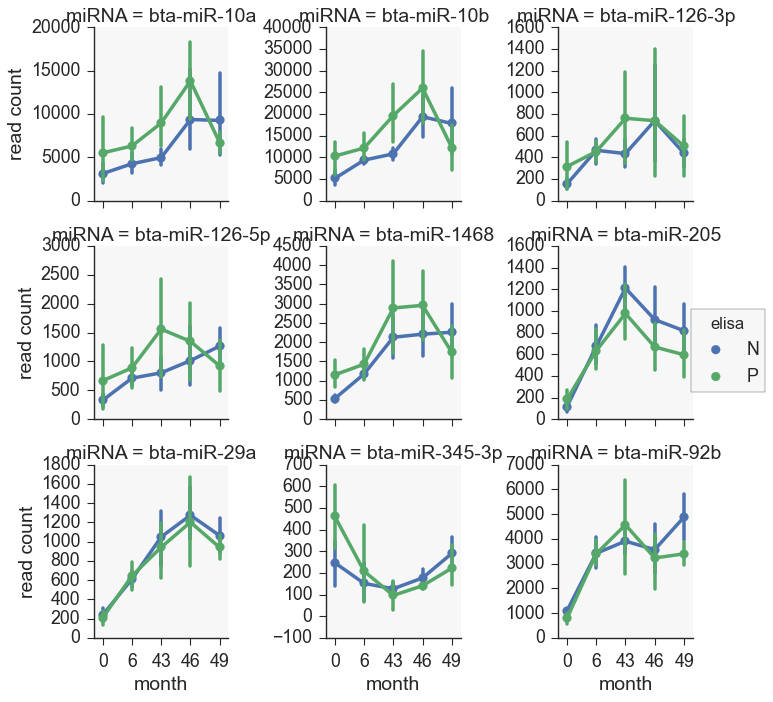

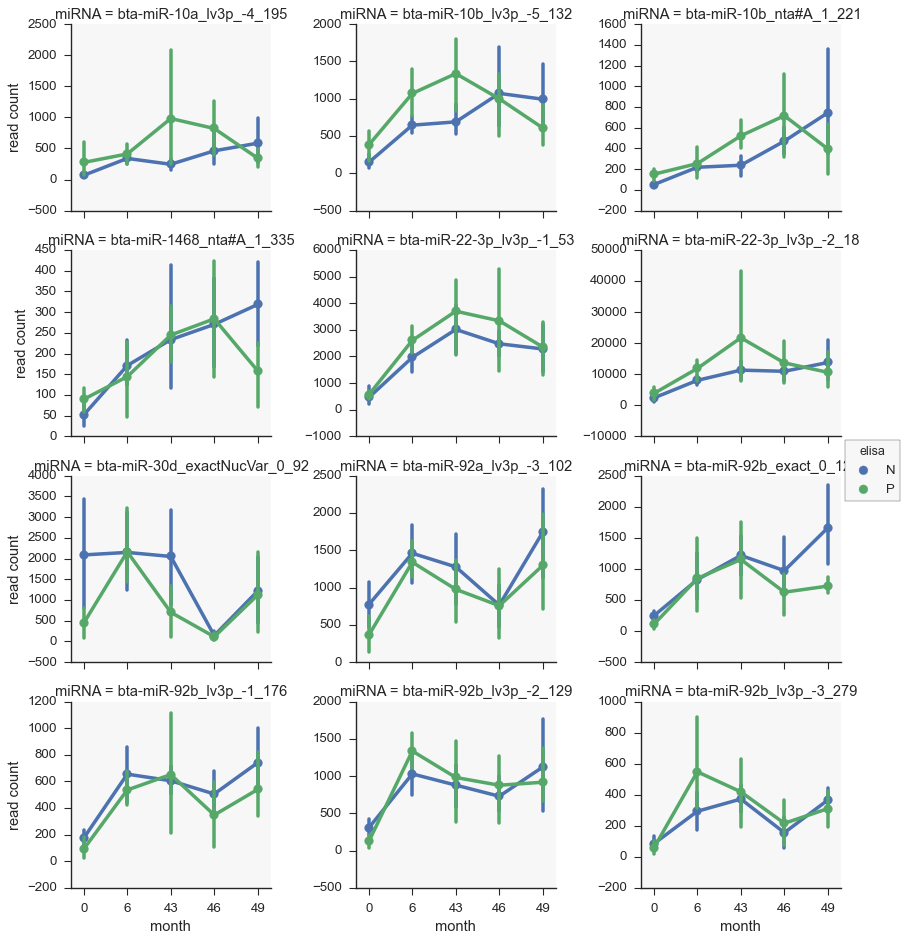

In [34]:
names = deknown.name
c,normcols=mdp.getColumnNames(k)
#names = ['bta-miR-22-3p']
df = k.ix[names][normcols]
tm = meltdata(df,cm1,c)
g = sns.factorplot('month','read count','elisa', tm, col='miRNA', kind="point",
                            col_wrap=3,size=3,aspect=1,legend_out=True,sharey=False)
plt.savefig('de_known.png')

names = deiso.name.unique()[:12]
#names = ['bta-miR-22-3p_lv3p_-1_53','bta-miR-22-3p_lv3p_-2_18']
c2,normcols2=srb.getColumnNames(kiso)
df = kiso.ix[names][normcols2]
tm = meltdata(df,cm2,c2)
sns.set_context("notebook", font_scale=1.2)
g = sns.factorplot('month','read count','elisa', tm, col='miRNA', kind="point",
                            col_wrap=3,size=3,aspect=1.2,legend_out=True,sharey=False)
plt.savefig('de_isomirs.png')

              name            isoClass     mean_norm      perc
8    bta-miR-22-3p   lv3p|lv3pE|lv3p#1  18397.631579  0.607802
18   bta-miR-22-3p  lv3p|lv3pT|lv3p#-2  10485.719298  0.238292
53   bta-miR-22-3p  lv3p|lv3pT|lv3p#-1   2218.438596  0.054569
108  bta-miR-22-3p               exact    766.842105  0.023588
144  bta-miR-22-3p   lv3p|lv3pE|lv3p#1    422.254545  0.013871
162  bta-miR-22-3p   lv3p|lv3pE|lv3p#1    510.258065  0.011960
164  bta-miR-22-3p   lv3p|lv3pE|lv3p#1    670.914286  0.011753


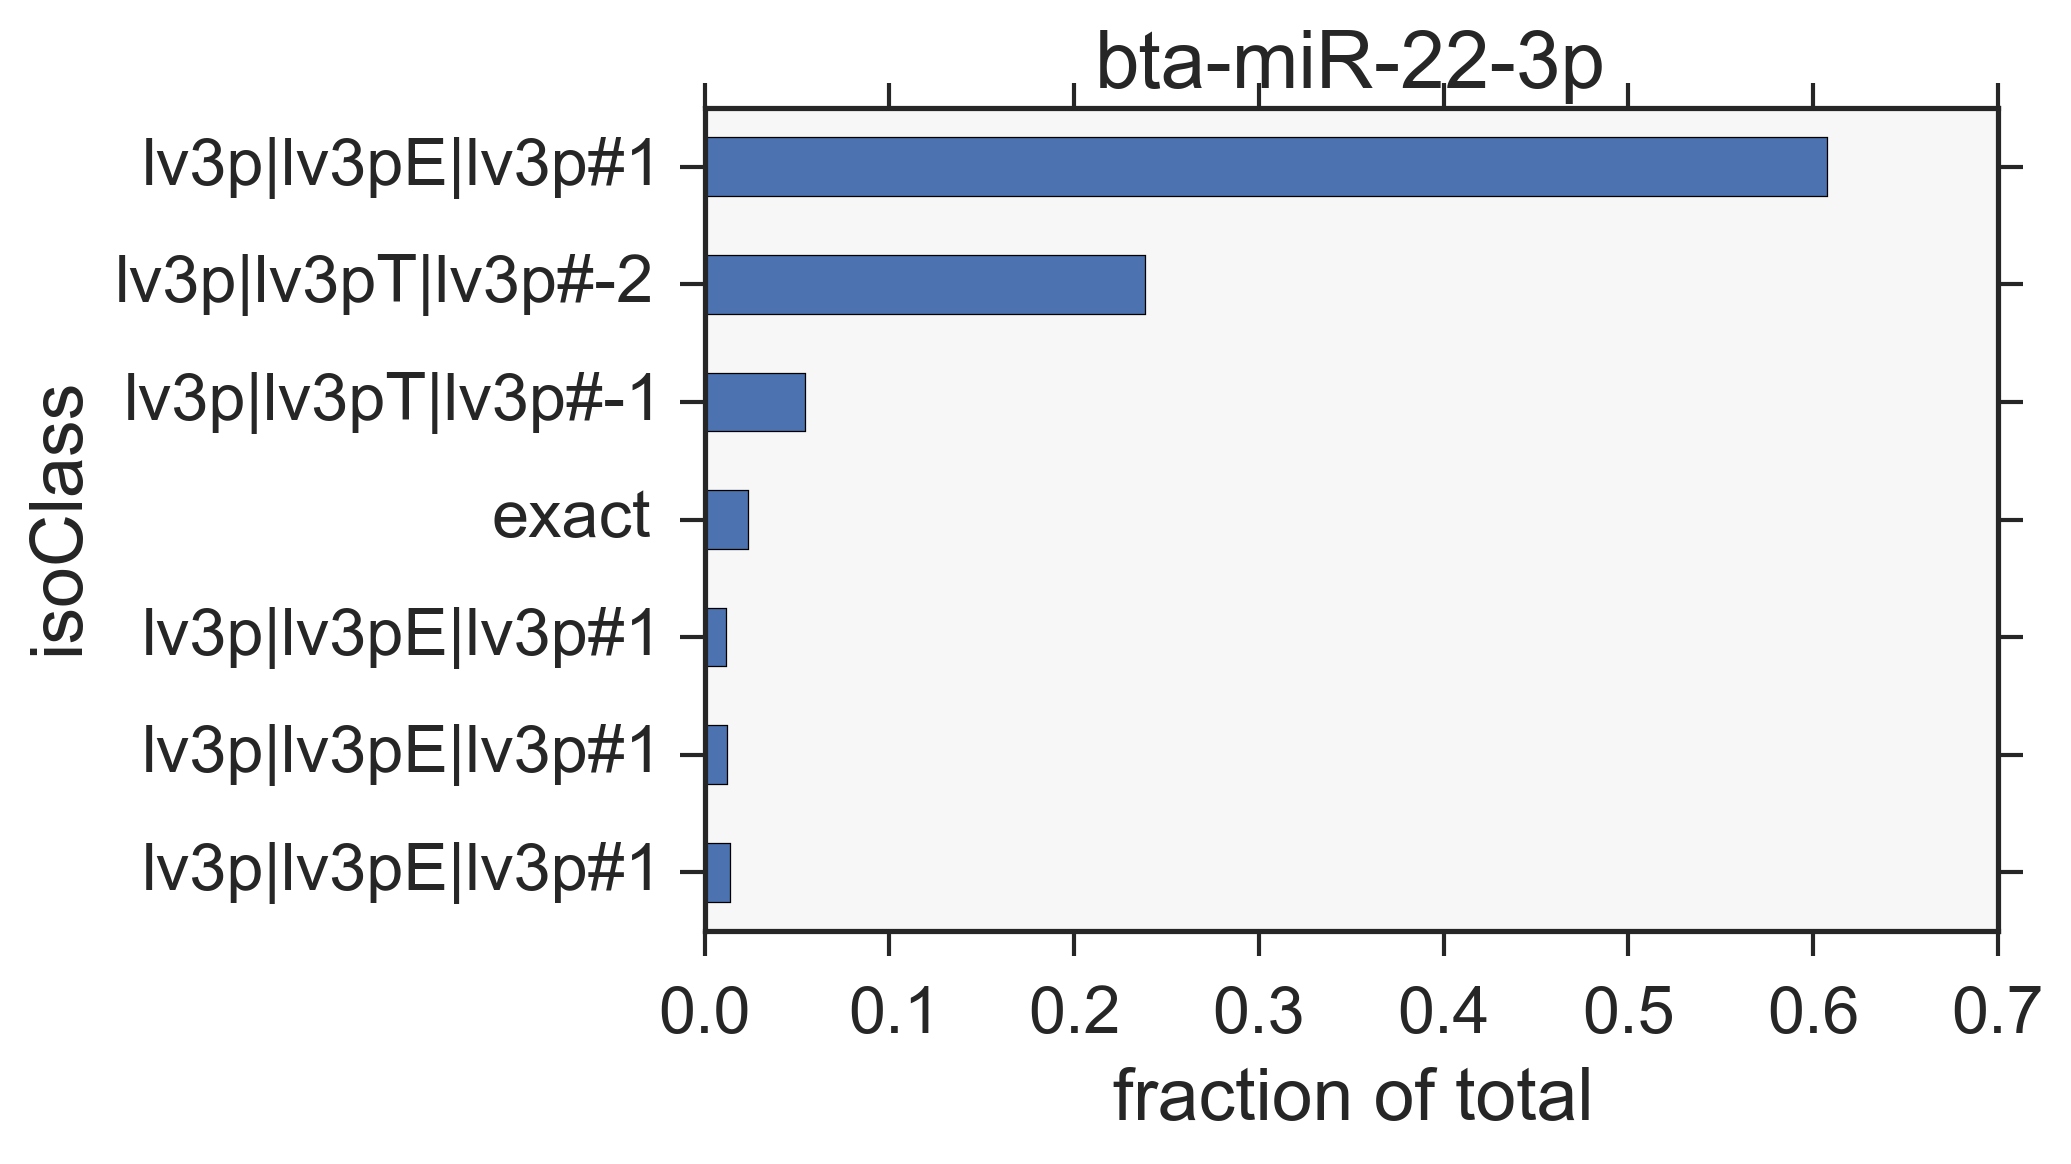

In [22]:
inames = deiso.name.apply( lambda x : x.split('_')[0])
#print deiso.sort('name')
#domiso = pd.read_csv('analysis/srnabench_isomirs_dominant.csv')
#print domiso[domiso.name.isin(inames)]

def plotIsoDist(iso,name):
    #add this to srnabench
    x=iso[iso.name==name]
    x=x[x.perc>0.01]
    print x[['name','isoClass','mean_norm','perc']]
    cols,normcols=srb.getColumnNames(iso)
    x['std'] = x[normcols].std(1)
    x = x.sort('mean_norm')
    x.plot(x='isoClass',y='perc',kind='barh',grid=False,legend=False,figsize=(7,4))
    plt.xlabel('fraction of total')
    plt.title(name)
    plt.tight_layout()
    plt.savefig('%s_isomirs.png' %name)
    
plotIsoDist(iso,'bta-miR-22-3p')
#plotIsoDist(iso,'bta-miR-23a')


In [167]:
def meancc(df):
    cc = df.corr()
    print cc
    cc.values[np.tril_indices_from(cc)] = np.nan
    print cc.unstack().mean()

['s22(norm)', 's23(norm)', 's28(norm)', 's29(norm)', 's46(norm)', 's47(norm)', 's49(norm)']
           s22(norm)  s23(norm)  s28(norm)  s29(norm)  s46(norm)  s47(norm)  s49(norm)
s22(norm)   1.000000   0.972009   0.747840   0.985974   0.686514   0.762541   0.705904
s23(norm)   0.972009   1.000000   0.605918   0.951201   0.552713   0.641575   0.587907
s28(norm)   0.747840   0.605918   1.000000   0.800745   0.878925   0.909547   0.866583
s29(norm)   0.985974   0.951201   0.800745   1.000000   0.727341   0.799722   0.772170
s46(norm)   0.686514   0.552713   0.878925   0.727341   1.000000   0.982221   0.922296
s47(norm)   0.762541   0.641575   0.909547   0.799722   0.982221   1.000000   0.921521
s49(norm)   0.705904   0.587907   0.866583   0.772170   0.922296   0.921521   1.000000
0.799103191858


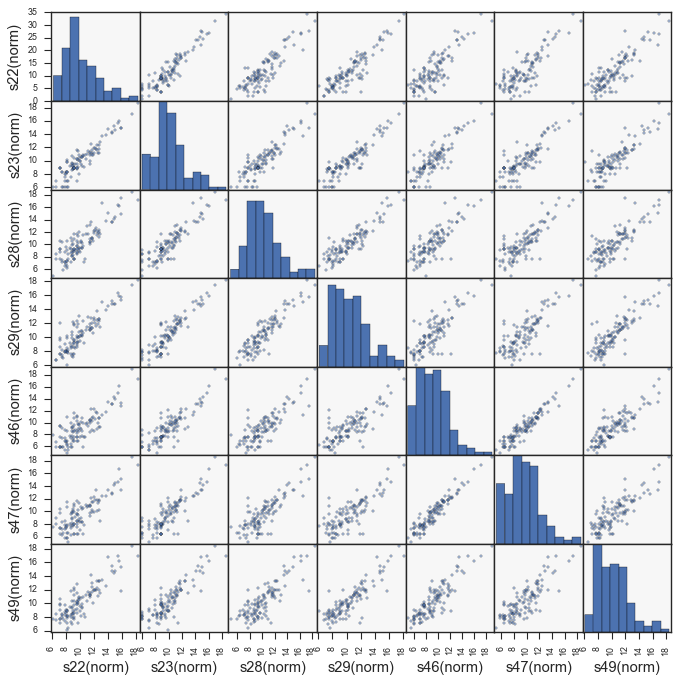

In [188]:
#variation between samples
df = mdp.getResults(path1)
df = mdp.filterExprResults(df,meanreads=150,score=0)
df=df[df>0]
#cols,normcols=mdp.getColumnNames(df)
cm = mdp.getLabelMap(path1, 'mapdata_labels.csv')
c1 = cm[(cm.month==0) & (cm.elisa=='N')].id
#c1 = cm[(cm.animal==1366)].id
nc1 = [i+'(norm)' for i in c1]
print nc1
a=nc1[0]
b=nc1[2]

ax=pd.scatter_matrix(np.log2(df[nc1]),figsize=(10,10))
meancc(df[nc1])
#df.plot(x=a,y=b,kind='scatter',logx=True,logy=True,figsize=(8,8),
#        s=20,alpha=0.9,grid=False)


          s17_norm  s50_norm  s57_norm  s36_norm  s44_norm
s17_norm  1.000000  0.956344  0.830931  0.957246  0.939349
s50_norm  0.956344  1.000000  0.896392  0.990243  0.966367
s57_norm  0.830931  0.896392  1.000000  0.885722  0.818527
s36_norm  0.957246  0.990243  0.885722  1.000000  0.936674
s44_norm  0.939349  0.966367  0.818527  0.936674  1.000000
0.917779342072


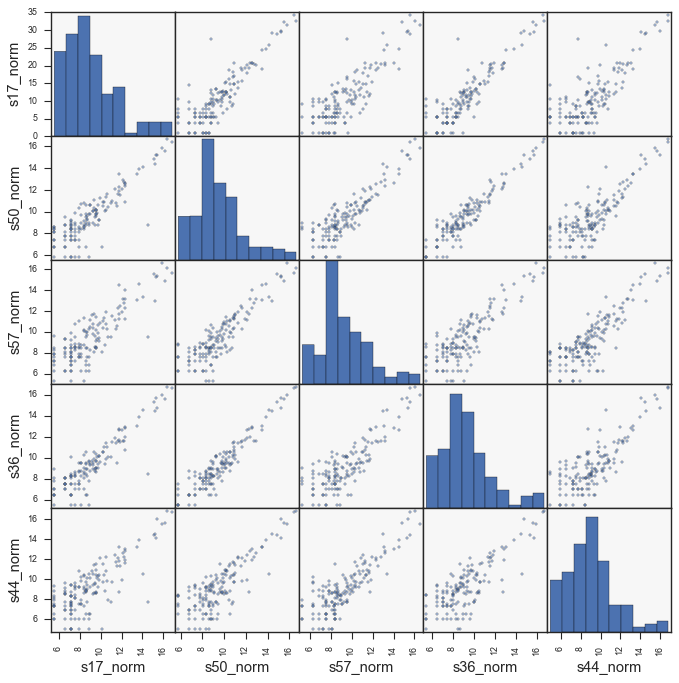

In [187]:
#isomir variation between samples
cm = srb.getLabelMap(path2, 'mapdata_labels.csv')
#get bio 'replicates'
c2 = cm[(cm.month==0) & (cm.elisa=='N')].id
c2 = cm[(cm.animal==1361)].id
nc2 = [i+'_norm' for i in c2]
#iso=iso[iso.mean_norm>150]
x = iso[nc2]
x = x[x>0]
ax=pd.scatter_matrix(np.log2(x),figsize=(10,10))
meancc(x)

            #miRNA     mean_norm         std        mean        cv
32   bta-miR-2284x   1760.543684   51.662408   59.508772  0.868148
25     bta-miR-92b   3262.856786   95.223066  105.473684  0.902814
60  bta-miR-23b-3p    507.514561   15.139659   16.596491  0.912220
28     bta-miR-378   1949.962456   64.863043   70.000000  0.926615
33    bta-miR-1468   1796.510351   55.425151   58.736842  0.943618
45  bta-miR-126-5p    924.957193   28.036541   29.666667  0.945052
5     bta-miR-181a  27344.995439  889.598141  930.070175  0.956485
41  bta-miR-99a-5p    999.098596   32.452404   33.807018  0.959931
6   bta-miR-423-3p  20892.499825  736.162159  755.087719  0.974936
8      bta-miR-10b  13844.905263  455.679754  456.877193  0.997379


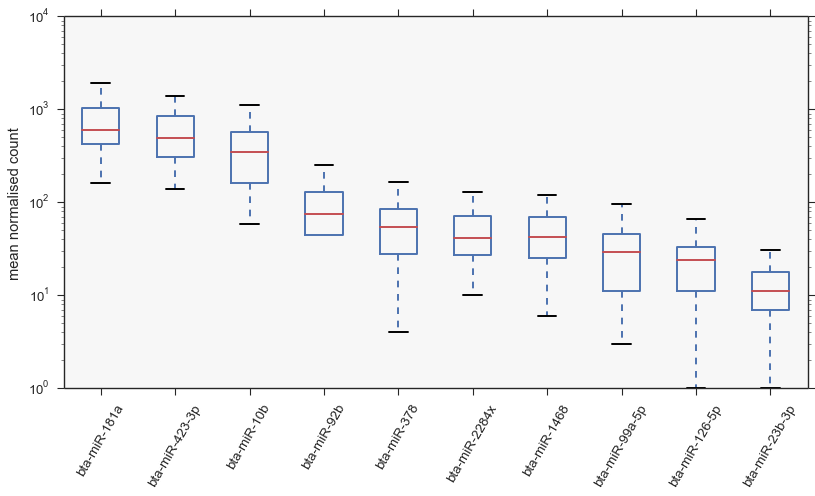

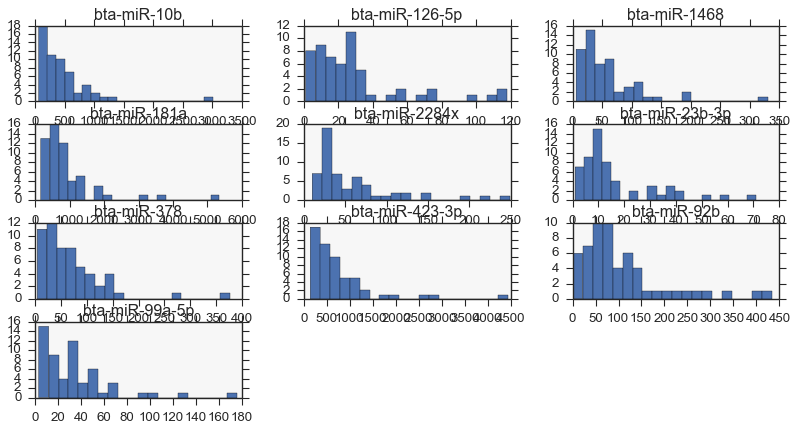

In [39]:
#normalisation stuff
#stability of each miRNA over samples?
d = getexprdata(douwe, norm=False)
#d = getexprdata(iconmap, norm=False)
cols,normcols=mdp.getColumnNames(douwe)
#need to re-add mean,std and cv to mirdeep getResults so this is simplified
d['mean']=douwe[cols].mean(1)
d['cv'] = d['std']/d['mean']
d = d.sort('cv')[:10]
print d
names=d['#miRNA']
d=douwe.set_index('#miRNA')
d=d[d.index.isin(names)]
x=d[cols].T
ax=x.plot(kind='box',grid=False,figsize=(12,6),logy=True)
ax.set_xticklabels(d.index,rotation=60)
plt.ylabel('mean normalised count')
ax=x.hist(bins=20,grid=False,figsize=(12,6))


In [ ]:
#isomiR dependency on elisa?
